In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
from __future__ import division

%matplotlib inline  

matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)


In [3]:
def p( x, t=1.0 ):
    return np.exp( -10*t*((x-2)**2) ) + 0.3*np.exp( -0.5*10*t*((x+1)**2) )

def metrop_hastings(timesteps, ss=1):
    xs=[0]
    acceptance = 0
    for t in xrange(timesteps):
        x = xs[t]
        x_prime = np.random.normal(x, ss)
        alpha = p(x_prime) / p(x)
        r = np.min([1, alpha])
        u = np.random.uniform(0,1)
        
        if u < r:
            acceptance += 1
            xs.append( x_prime )
        else:
            xs.append(x)
    print("Acceptance Ratio for ss=%.1f: %.2f" % (ss, (acceptance / timesteps)))
    return xs

def plot_mcmc_over_time(figures, ss):
    colors = ["blue", "red", "green", "yellow", "black", "grey"]
    index = 0
    plt.title("Proposal ss=%.1f" % ss)
    plt.xlabel("Time")
    plt.ylabel("State")
    for f in figures: 
        f = f[:1000]
        plt.plot(xrange(len(f)), f, color=colors[index])
        index+=1
    plt.show()
    
def plot_mcmc(data, x_curve, y_curve, ss):
    plt.title("Proposal ss=%.1f" % ss)
    plt.plot(x_curve, y_curve, color="green")
    plt.hist(data, normed = True, bins=100)
    plt.show()
    
def hmc(U, grad_U, epsilon, L, current_q):
    q = current_q
    p = np.random.normal()#size = len(q))
    current_p = p
    
    p = p - epsilon * grad_U(q) / 2.0
    
    
    for i in xrange(L):
        q = q + epsilon * p
        if i != L - 1:
            p = p - epsilon * grad_U(q)
        
    p = p - epsilon * grad_U(q) / 2.0
    p = -p
    
    
    current_U = U(current_q)
    current_K = np.sum(current_p**2) / 2.0
    proposed_U = U(q)
    proposed_K = np.sum(p**2) / 2.0
    
    
    if np.random.uniform() < np.exp(current_U - proposed_U + current_K - proposed_K):
        return q, 1    # accept
    else:
        return current_q, 0 # reject

In [4]:
ss_01 = []
ss_1 = []
ss_10 = []
times = 3
for x in xrange(times):
    ss_01.append( metrop_hastings(10000, 0.1) )
    ss_1.append( metrop_hastings(10000, 1) )
    ss_10.append( metrop_hastings(10000, 10) )


Acceptance Ratio for ss=0.1: 0.90
Acceptance Ratio for ss=1.0: 0.30
Acceptance Ratio for ss=10.0: 0.06
Acceptance Ratio for ss=0.1: 0.90
Acceptance Ratio for ss=1.0: 0.31
Acceptance Ratio for ss=10.0: 0.06
Acceptance Ratio for ss=0.1: 0.90
Acceptance Ratio for ss=1.0: 0.31
Acceptance Ratio for ss=10.0: 0.05


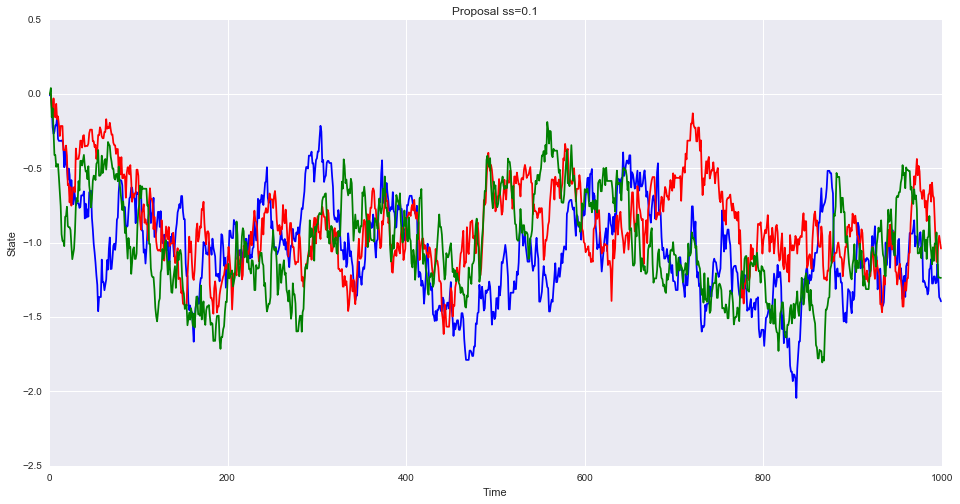

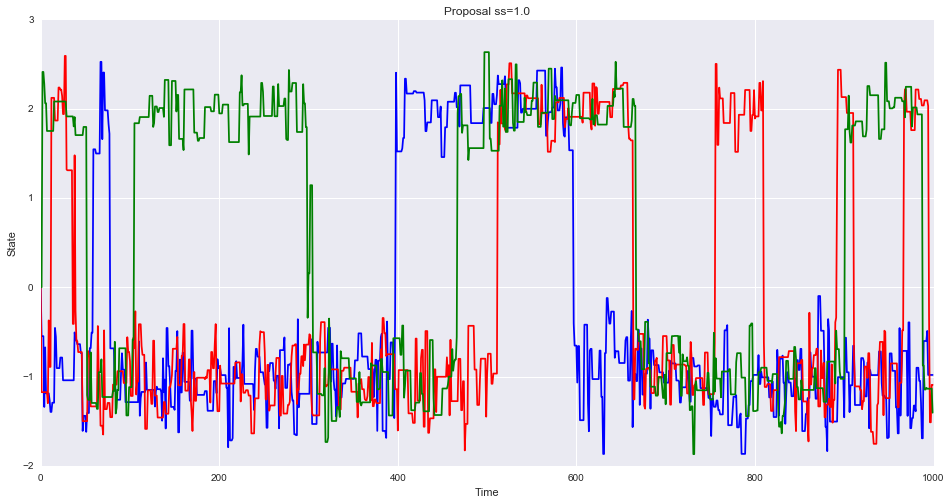

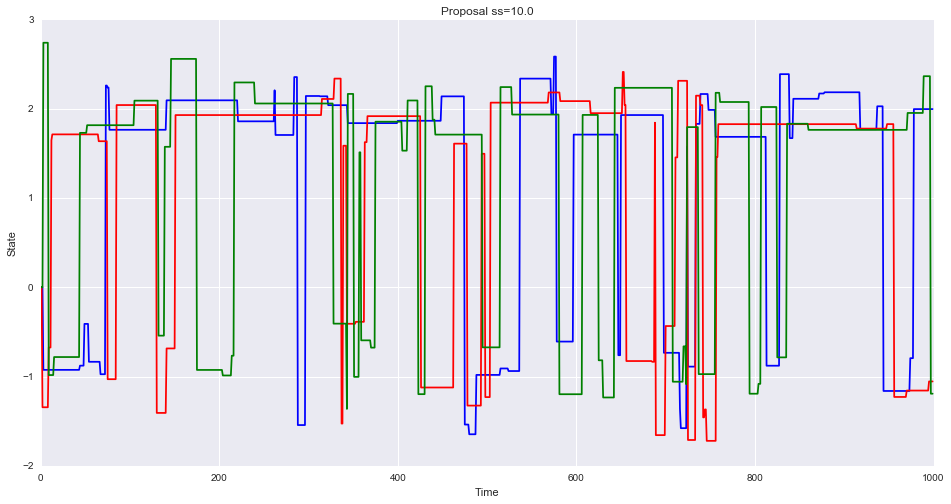

In [5]:
plot_mcmc_over_time(ss_01, 0.1)
plot_mcmc_over_time(ss_1, 1)
plot_mcmc_over_time(ss_10, 10)


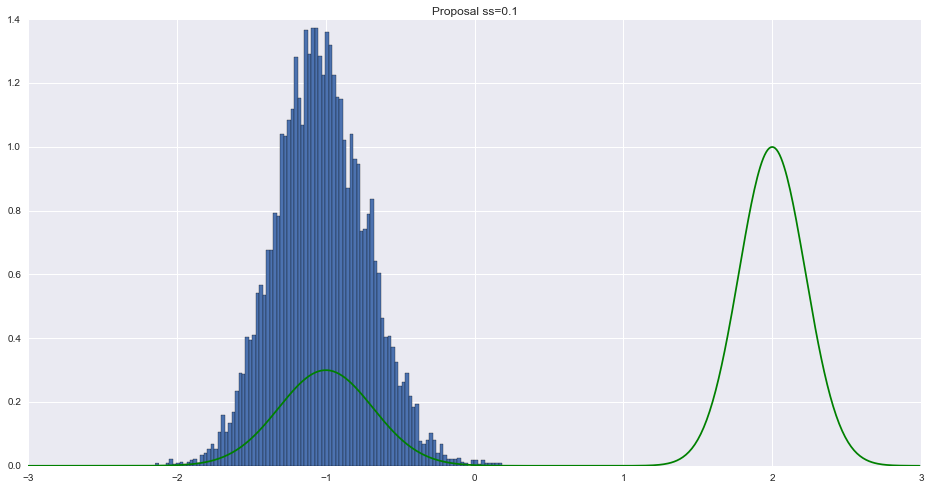

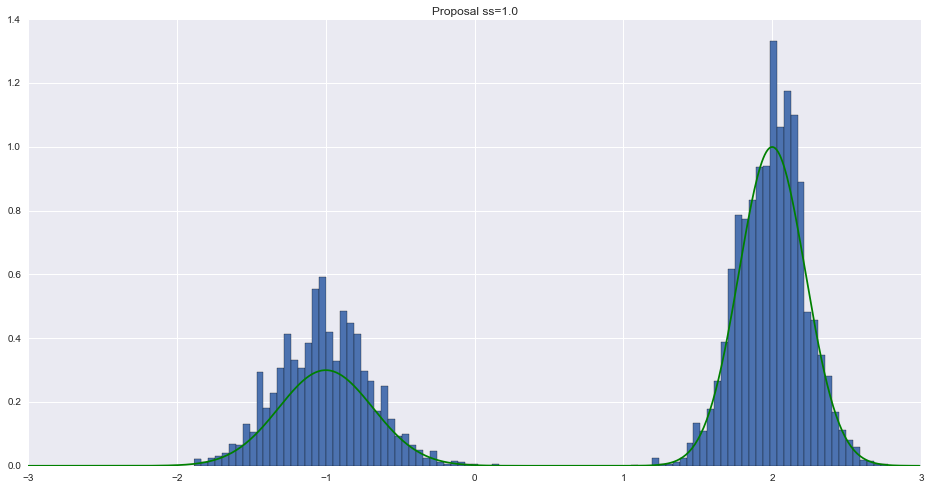

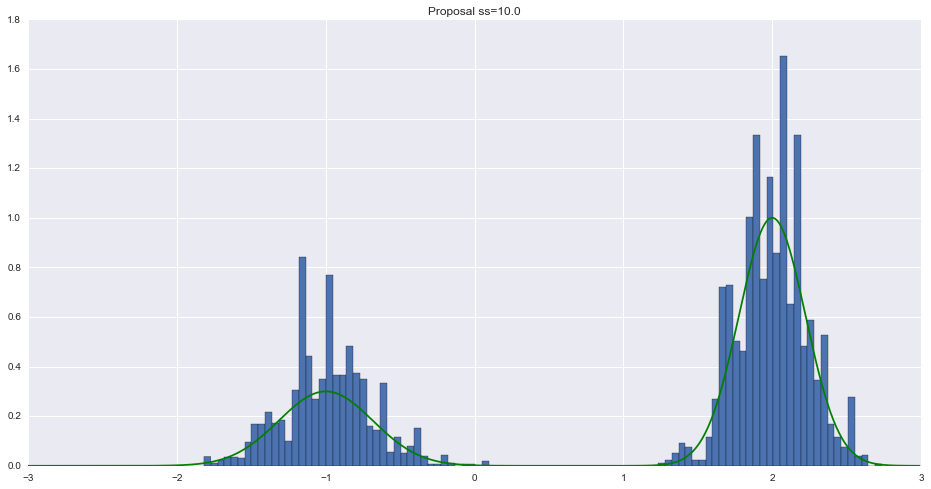

In [6]:
x_curve = np.arange(-3, 3, 0.01)
y_curve = [p(x) for x in x_curve]

plot_mcmc(ss_01[0], x_curve, y_curve, 0.1)
plot_mcmc(ss_1[0], x_curve, y_curve, 1)
plot_mcmc(ss_10[0], x_curve, y_curve, 10)

In [9]:
from autograd import grad
import autograd.numpy as np

def hmc_full():
    qs = [0]
    accepted = 0

    epsilon = 1

    def U(q):
        return -np.log(p(q))

    grad_U = grad(U)
    
    for n in xrange(10000):
        q, accept = hmc(U, grad_U, epsilon, 1, qs[n])
        accepted += accept
        qs.append(q)
    return qs, accepted

qs_full = []
for x in xrange(3):
    qs, accepted = hmc_full()
    print "Acceptance Ratio for Hamiltonian", accepted / 10000
    qs_full.append(qs)


Acceptance Ratio for Hamiltonian 0.0682
Acceptance Ratio for Hamiltonian 0.0954
Acceptance Ratio for Hamiltonian 0.0704


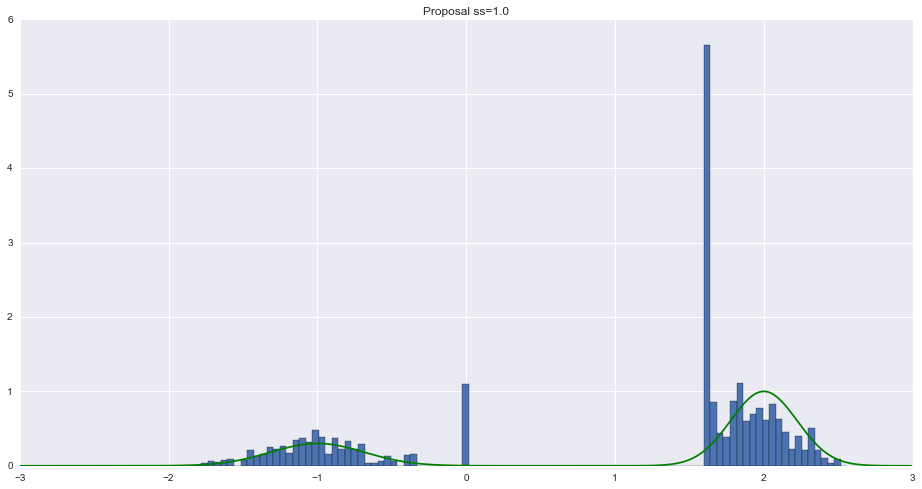

In [11]:
plot_mcmc(qs_full[2], x_curve, y_curve, 1)


In [ ]:
plot_mcmc_over_time(qs_full, 1)

# Observations

### 1. What was the acceptance rate of each algorithm? 

    The acceptance rate for Metropolis Hastings depended on the step size. The ratios were posted above but here they are again. 
    
    Acceptance Ratio for ss=0.1: 0.90 
    
    Acceptance Ratio for ss=1.0: 0.32
    
    Acceptance Ratio for ss=10.0: 0.06
    
    The acceptance ratio for Hamiltonian was 0.101

### 2. Why don't some inference algorithms explore both modes of the density?

    The algorithms that have a smaller stepsize seem to stay away from one of the modes because they make very small steps in the positive or negative direction. Therefore they don't move to the other mode without first returning to the previous one.

### 3. Why do some algorithms stay in the same state repeatedly? Is this good or bad?

    This can be both good and bad. This generally happens when the stepsize is larger and the acceptance rate is low. While a good balance is important to have, limiting the time it switches between the modes helps the algorithm make controlled switches that have real purpose upon switching. 
    

### 4. What were the best values for the variance of the momentum variables and the timestep you found? How did you know that they were good?

    The momentum variable that worked best seems to be 1, and at some level, 10 as well. 0.1 was too small of a momentum and did not mix between the two nodes. 10 was almost an overfit of the data, and 1 seemed to fit the data just right. As for timestep, a lower timestep of 1000 was too low. The new data did not fit itself in well with the graph, and 10000 was a good number. Trying a number like 50000 actually gave some good results on the first plot, but made the mcmc_over_time plot unreadable. 